In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

## 0.Load Data

In [2]:
# load EMG data for Subject #2
EMG_file_name='s2/S2_A1_E1.mat'
emg_data = loadmat(EMG_file_name)

print(f"What kind of data structure are we working with? {type(emg_data)}")
print(f"What are the keys of the data structure? {[key for key in emg_data.keys()]}")

What kind of data structure are we working with? <class 'dict'>
What are the keys of the data structure? ['__header__', '__version__', '__globals__', 'subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition']


In [3]:
emg= emg_data["emg"].copy()
stimulus = emg_data["restimulus"] 
repetition = emg_data["rerepetition"] 

print(f'What are the shape of the data that we are working with? \nEMG: {emg.shape}, \nStimulus {stimulus.shape}, \nRepetition {repetition.shape}')

What are the shape of the data that we are working with? 
EMG: (100686, 10), 
Stimulus (100686, 1), 
Repetition (100686, 1)


## 1. Preprocessing

### 1.1 Apply bandpass filter
Before preprocessing, we visualize the rawdata for subject2.

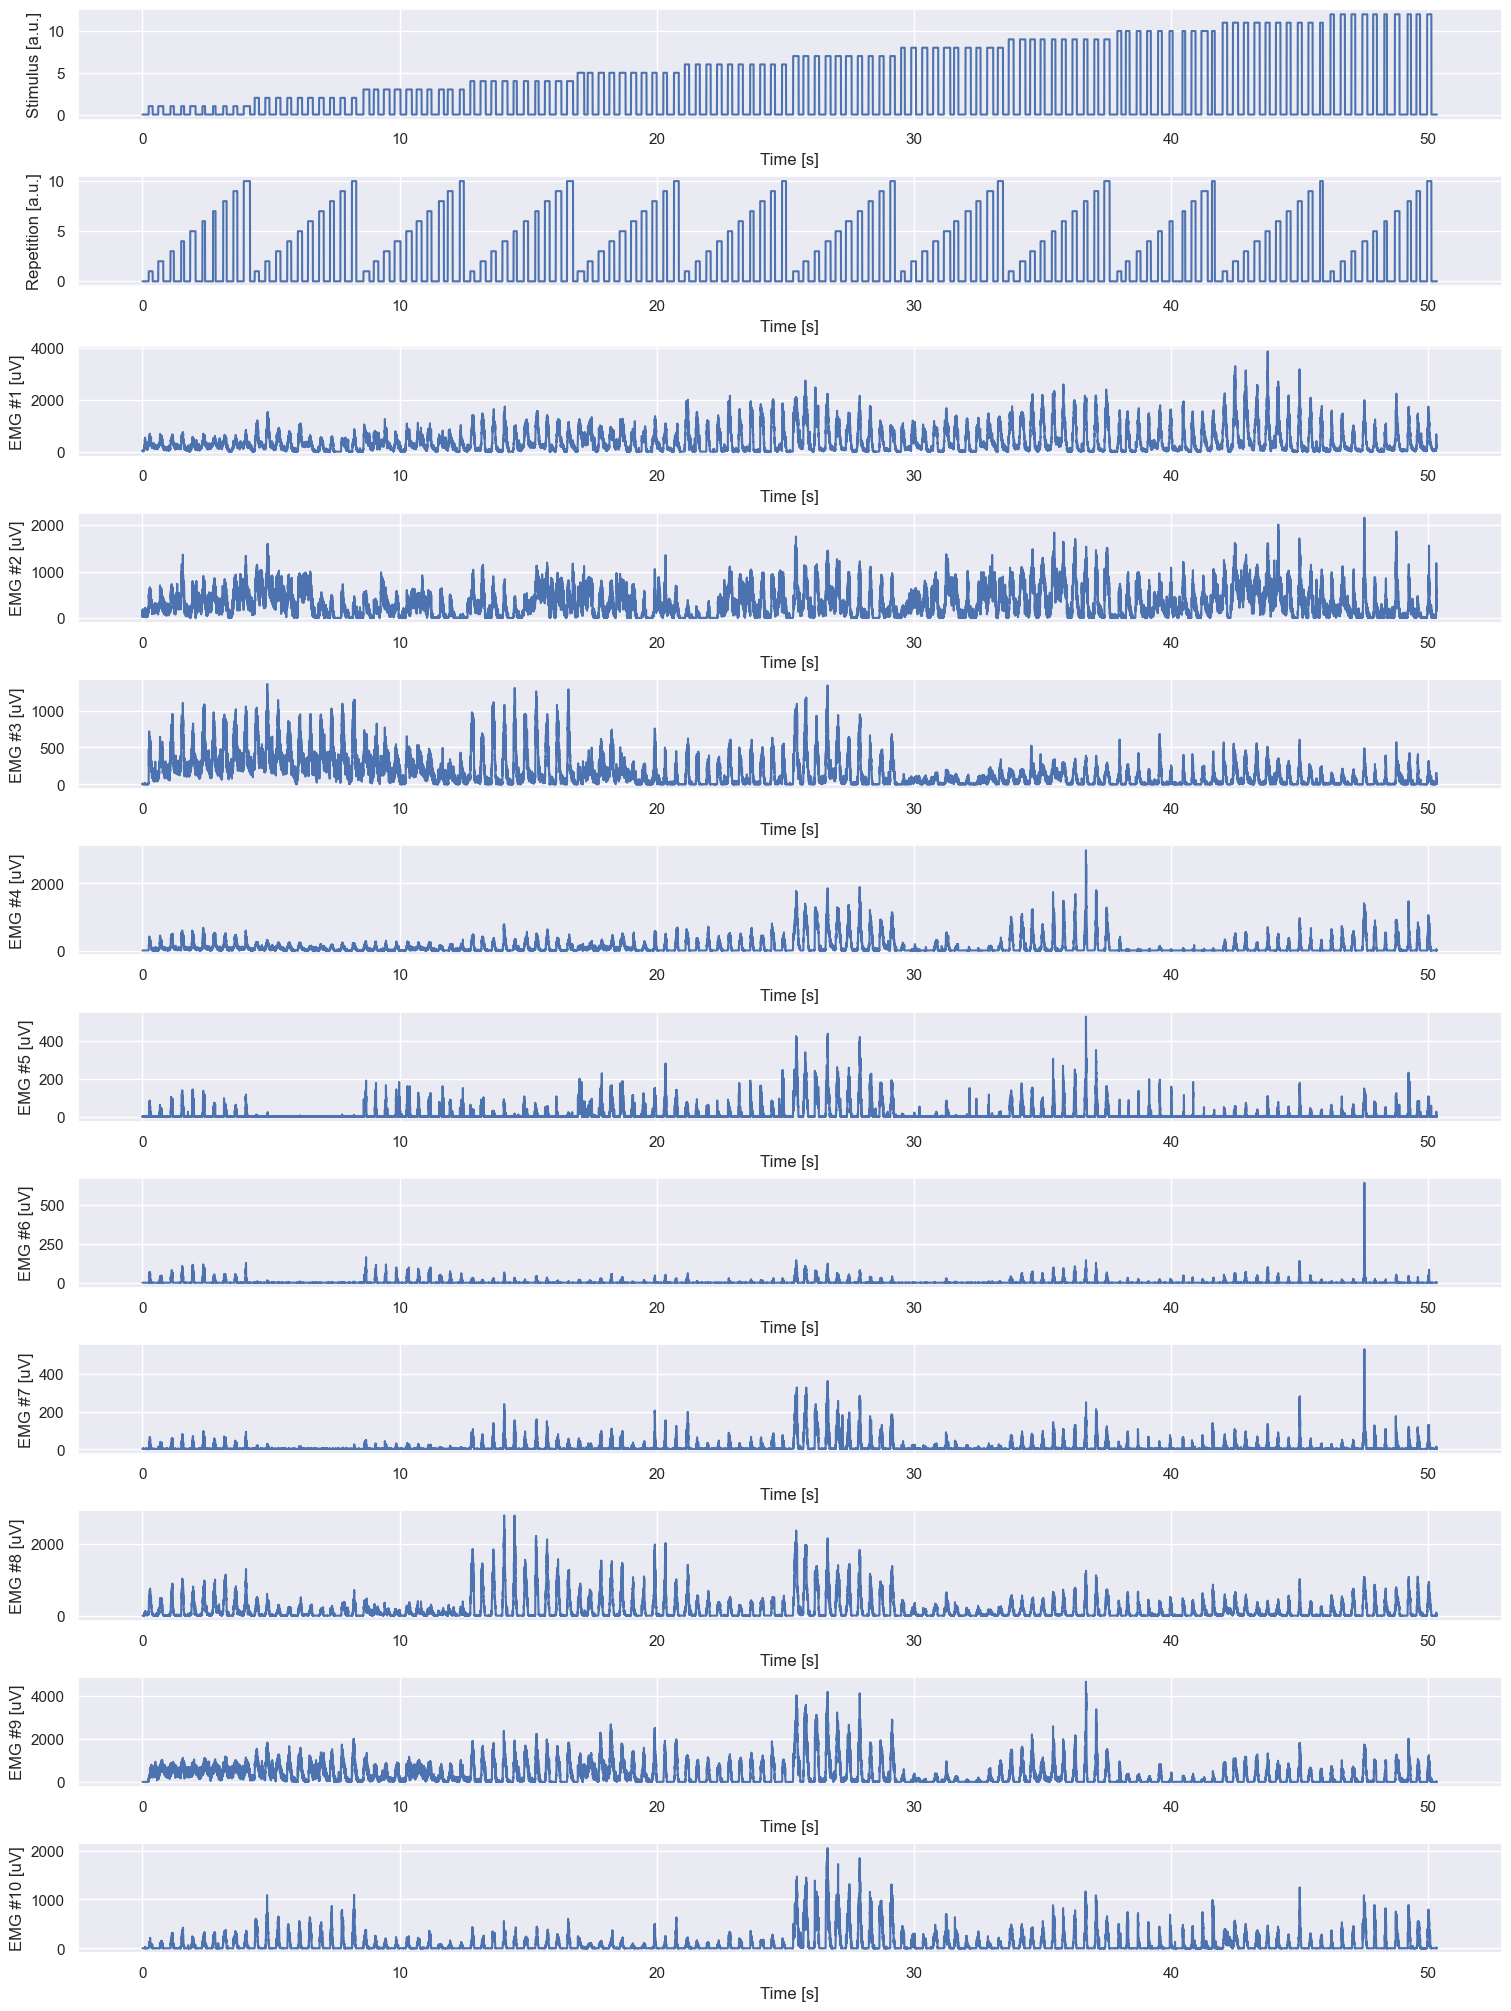

In [4]:
n_channels = emg.shape[1]

fs = 2000 # According to the references, sampling frequency here is 2000 Hz.

time_steps = np.arange(0,emg.shape[0]/fs, 1/fs)

fig, ax = plt.subplots(n_channels+2, 1, constrained_layout=True, figsize=(15, 20))

ax[0].plot(time_steps, stimulus)
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Stimulus [a.u.]")

ax[1].plot(time_steps, repetition)
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Repetition [a.u.]")

for channel_idx in range(n_channels):
    ax[channel_idx+2].plot(time_steps, emg[:, channel_idx]*1000)
    ax[channel_idx+2].set_xlabel("Time [s]")
    ax[channel_idx+2].set_ylabel(f"EMG #{channel_idx+1} [uV]")

Because the sEMG data was gathered using OttoBock MyoBock 13E200 surface EMG electrodes3, it is supposed to be amplified, bandpass-filtered and rectified version of the raw sEMG signal.

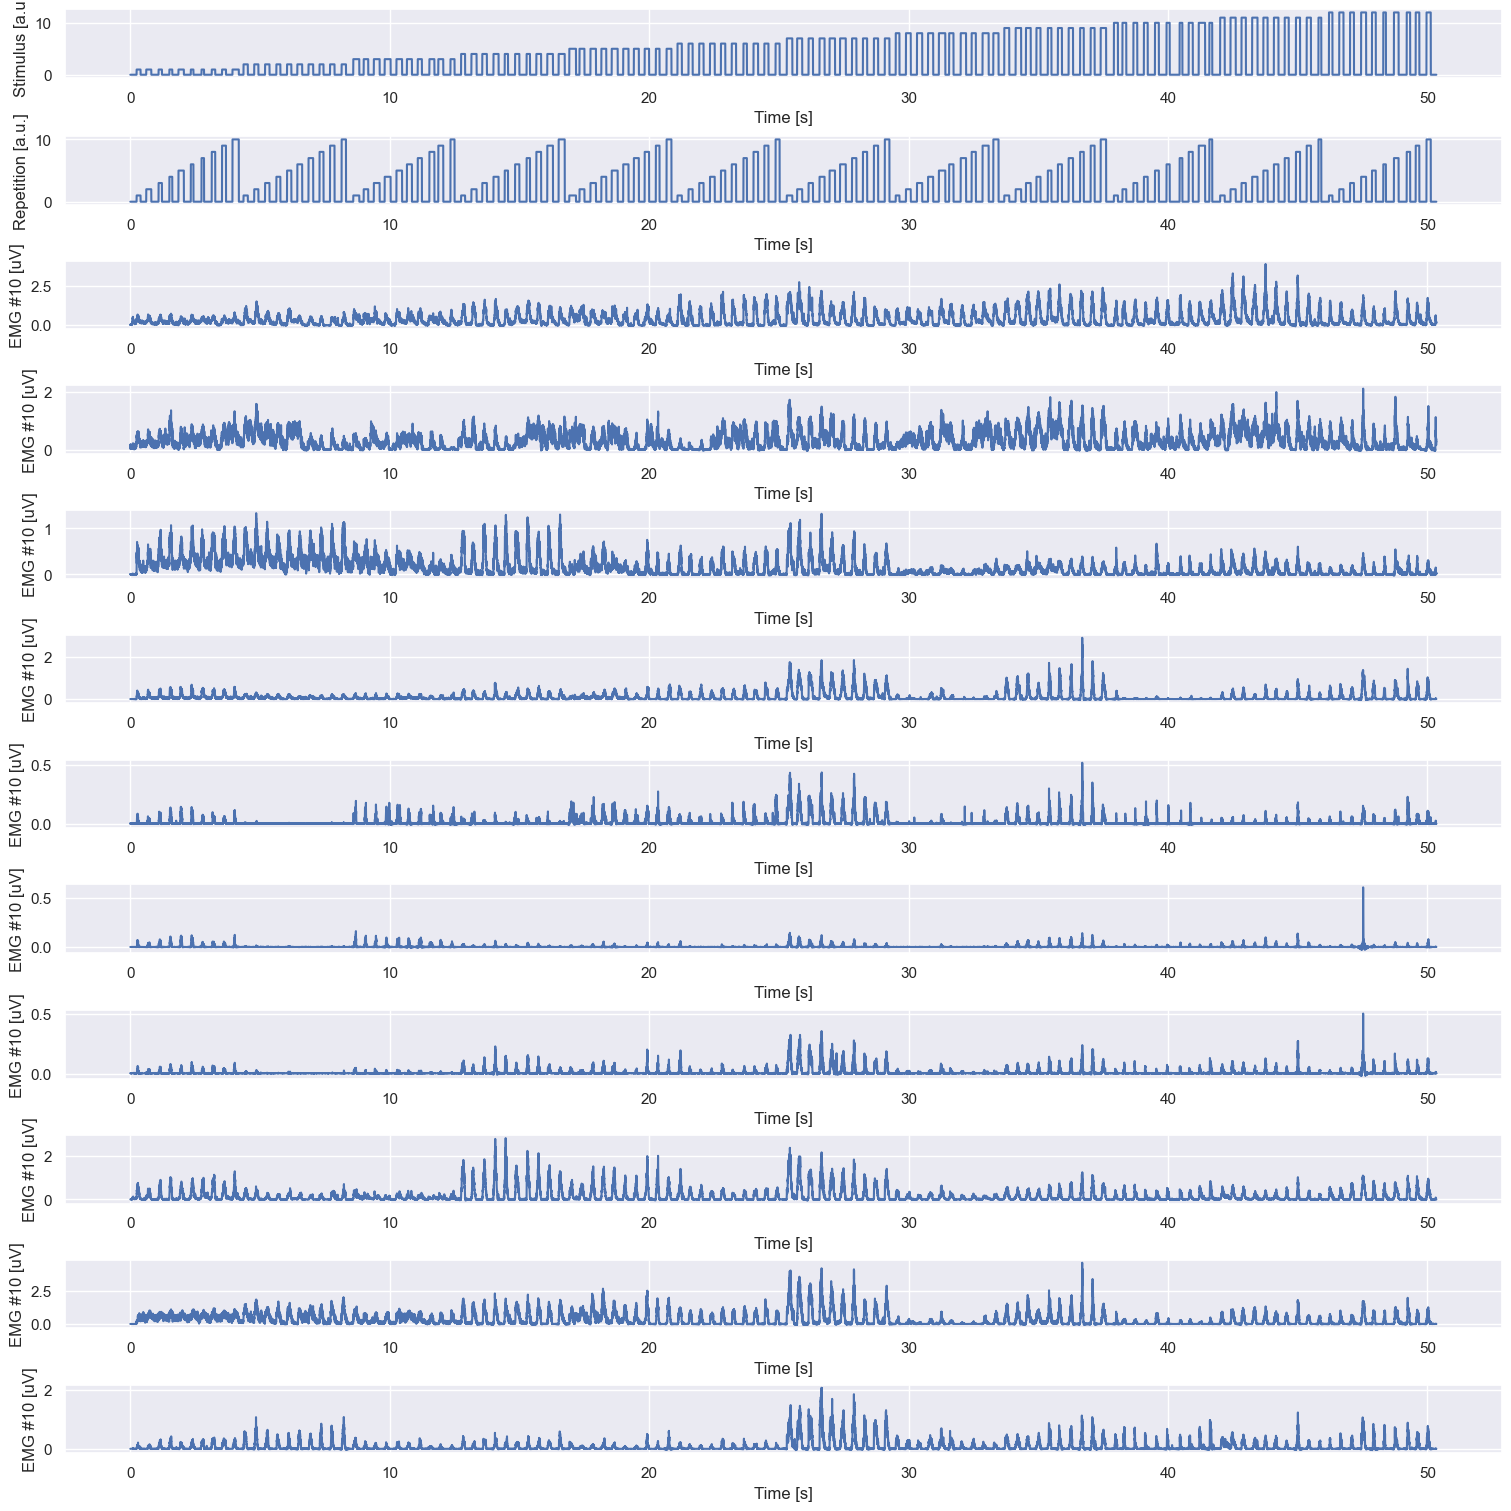

In [5]:
bandpass_cutoff_frequencies_Hz = (15, 500) 
sos = butter(N=0, Wn=bandpass_cutoff_frequencies_Hz, fs=fs, btype="bandpass", output="sos") 
emg_filtered = sosfiltfilt(sos, emg.T).T 

powergrid_noise_frequencies_Hz = [harmonic_idx*50 for harmonic_idx in range(1,3)] # removing 50Hz noise and its harmonics

for noise_frequency in powergrid_noise_frequencies_Hz:
    sos = butter(N=4, Wn=(noise_frequency - 2, noise_frequency + 2), fs=fs, btype="bandstop", output="sos")
    emg_filtered = sosfiltfilt(sos, emg_filtered.T).T

fig, ax = plt.subplots(n_channels+2, 1, constrained_layout=True, figsize=(15, 15))
ax[0].plot(time_steps, stimulus)
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Stimulus [a.u.]")

ax[1].plot(time_steps, repetition)
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Repetition [a.u.]")
for i in range(n_channels):
    ax[i+2].plot(time_steps, emg_filtered[:, i])
    ax[i+2].set_xlabel("Time [s]")
    ax[i+2].set_ylabel(f"EMG #{channel_idx+1} [uV]")

Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

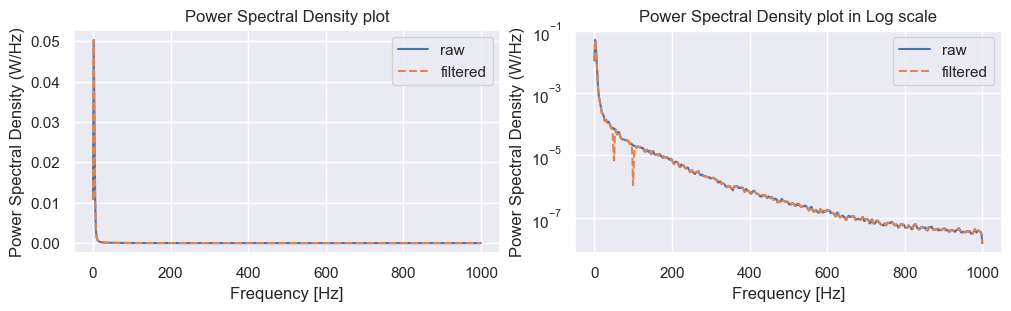

In [6]:
freqs_pre, Pxx_pre = welch(emg[:, 0], fs=fs, nperseg=1064)
freqs_post, Pxx_post = welch(emg_filtered[:, 0],fs = fs,  nperseg=1064)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].plot(freqs_post, Pxx_post, linestyle="--", label="filtered")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].semilogy(freqs_post, Pxx_post, linestyle="--", label="filtered")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

In [7]:
# -1 because 0 is not meaningful
n_stimuli = len(np.unique(stimulus)) - 1
n_repetitions = len(np.unique(repetition)) - 1
n_channels = emg_filtered.shape[1]

print(f'How many types of movement are there? {n_stimuli}')
print(f'How many repetitions are there? {n_repetitions}')
print(f'How many channels are there? {n_channels}')

How many types of movement are there? 12
How many repetitions are there? 10
How many channels are there? 10


In [8]:
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):

        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

number_of_samples_per_trial

array([[307., 390., 262., 226., 418., 204., 196., 270., 306., 489.],
       [334., 323., 344., 309., 333., 376., 362., 307., 348., 339.],
       [465., 352., 450., 460., 436., 389., 323., 388., 383., 316.],
       [310., 402., 357., 396., 255., 333., 263., 369., 438., 471.],
       [516., 382., 425., 379., 463., 411., 387., 343., 286., 377.],
       [337., 319., 337., 368., 338., 336., 268., 354., 319., 313.],
       [428., 392., 341., 393., 421., 445., 342., 328., 329., 358.],
       [289., 372., 406., 397., 498., 336., 415., 328., 472., 405.],
       [384., 424., 371., 316., 280., 314., 342., 284., 307., 421.],
       [311., 296., 299., 296., 301., 246., 213., 317., 493., 221.],
       [352., 403., 338., 416., 330., 355., 313., 322., 329., 219.],
       [270., 330., 300., 387., 295., 204., 363., 267., 281., 329.]])

### 1.2 Compute the envelop of the signal

In [9]:
mov_mean_size = 200
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg_filtered[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0)

Text(0.5, 0.98, 'Envelopes of the EMG signal (Example from Movement 1, Repetition 1)')

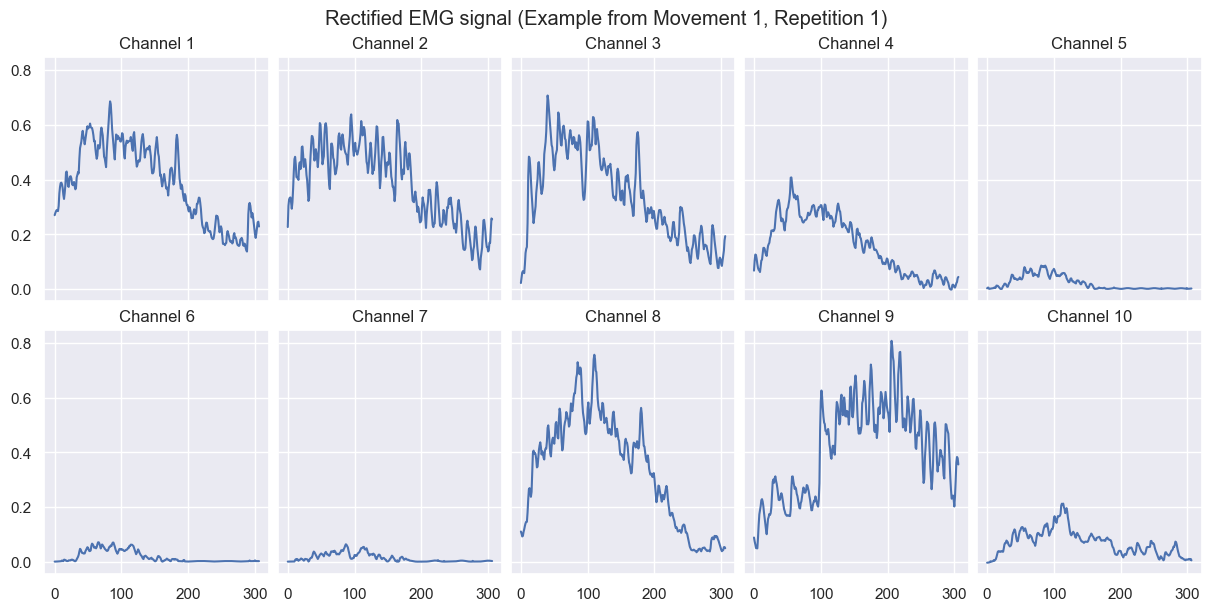

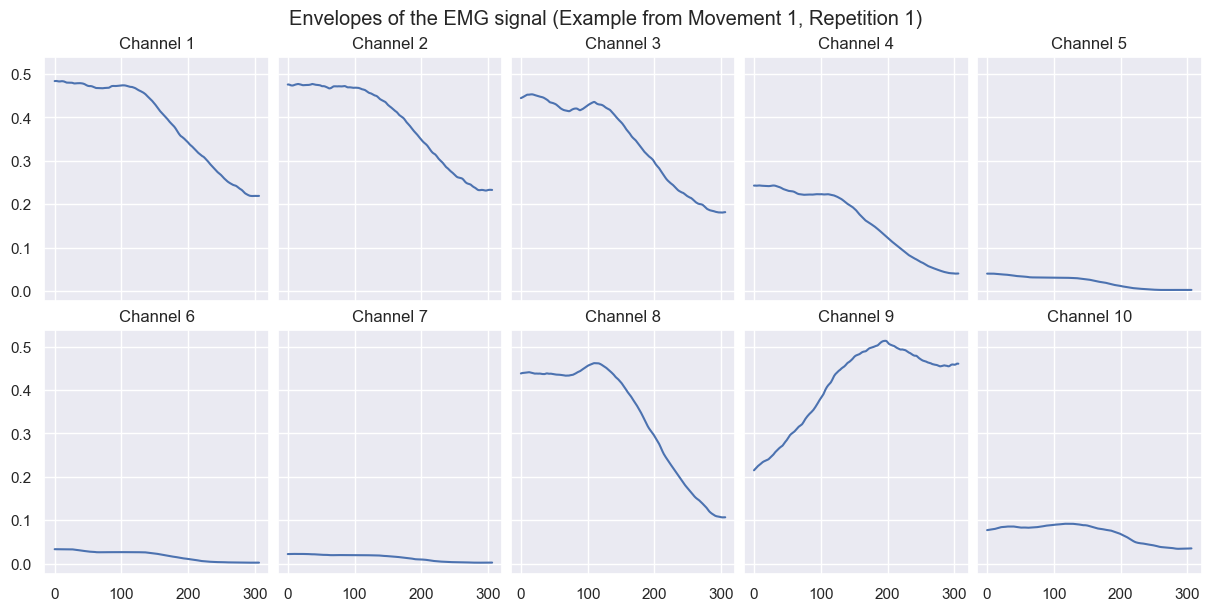

In [12]:
# Plot all the channels on the same y-scale
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

number_of_emg_channels = emg_filtered.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels):
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal (Example from Movement 1, Repetition 1)")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels):
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal (Example from Movement 1, Repetition 1)")

### 1.3 Visualizing across repetitions

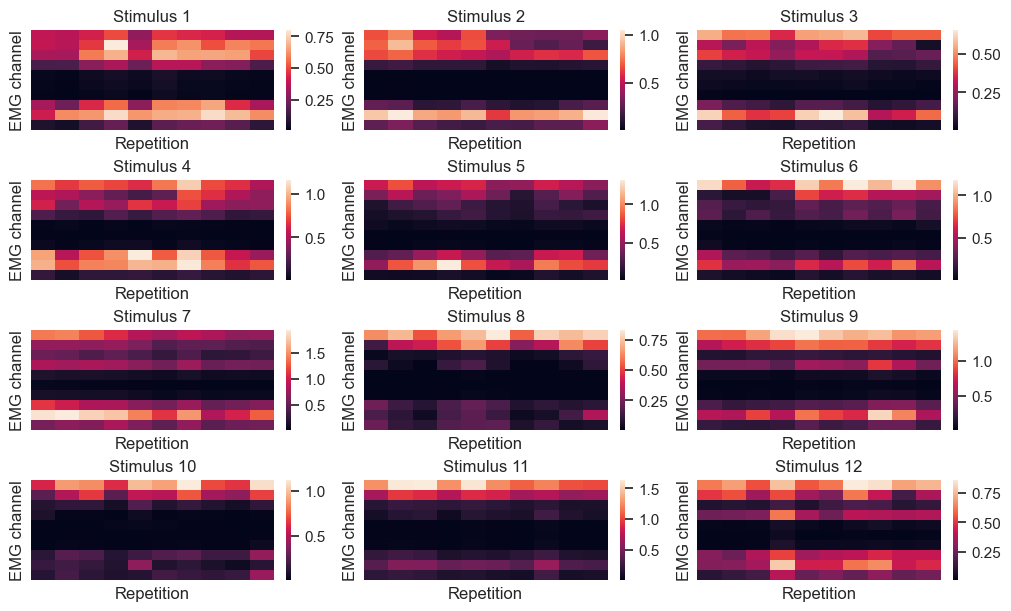

In [13]:
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        #mean across time for each channel
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0)

fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

## 3. Extract features from the trials (at least 5 different ones).

In [14]:
mean_std_norm = lambda x: (x - x.mean()) / x.std()

def build_dataset_from_ninapro(emg, stimulus, repetition, features=None, feature_norm=False):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions

    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)

    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0

    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()

            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                cur_feature = feature(emg[selected_tsteps, :])
                if feature_norm:
                    cur_feature = mean_std_norm(cur_feature)
                dataset[current_sample_index, selected_features] = cur_feature
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1

    # Return the constructed dataset and corresponding labels
    return dataset, labels

dataset dimension: (120, 60)
labels dimension: (120,)


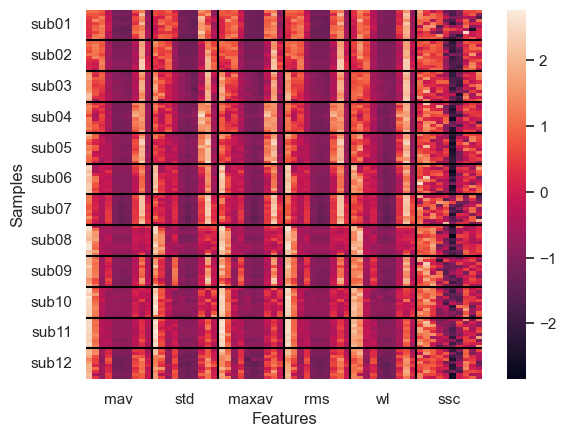

In [15]:
# Define the features

# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)

#Feel free to add more features, e.g. frequency domain features. (See https://doi.org/10.3390/s19204596 and https://doi.org/10.1088/0967-3334/24/2/307)


dataset, labels = build_dataset_from_ninapro(
    emg=emg_filtered,
    stimulus=stimulus,
    repetition=repetition,
    features=[mav, std, maxav, rms, wl, ssc],
    feature_norm=True
)

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")
sns.heatmap(dataset)
plt.xlabel('Features')
plt.ylabel('Samples')
plt.yticks(range(5, 116, 10), [f'sub%02d' % (x+1) for x in range(12)])
plt.xticks(range(5, 56, 10), ['mav', 'std', 'maxav', 'rms', 'wl', 'ssc'])

ax = plt.gca()
for x in range(10, dataset.shape[1], 10):  # 每隔10个特征
    ax.axvline(x=x, color='black', linestyle='-', linewidth=1.5)
for y in range(10, dataset.shape[0], 10):  # 每隔10个样本
    ax.axhline(y=y, color='black', linestyle='-', linewidth=1.5)


## 4. Perform classification on the data of subject 2 - Gradient Boost Decision Tree

n_training: 84, n_validation: 18, n_test: 18
Accuracy score: 0.6666666666666666


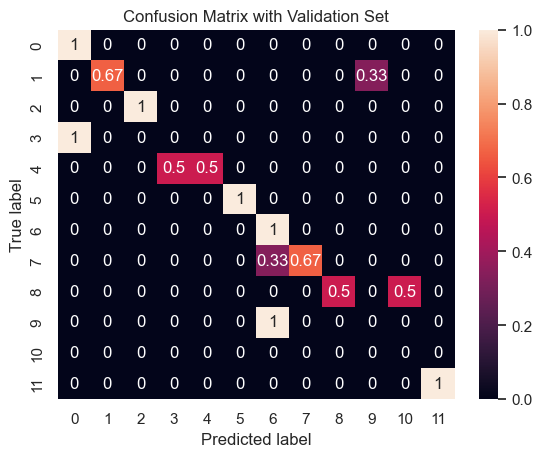

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Train:Validation:Test=70:15:15
X_train, X_temp, y_train, y_temp = train_test_split(dataset, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'n_training: {X_train.shape[0]}, n_validation: {X_val.shape[0]}, n_test: {X_test.shape[0]}')

# Normalizing the data
# StandardScaler is used to scale the features so that they have a mean of 0 and a standard deviation of 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z = scaler.transform(X_val)

# Classifier
clf = GradientBoostingClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
clf.fit(X_train_z, y_train)

# Predict in validation
y_pred = clf.predict(X_val_z)

# Accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy score: {accuracy}")

# Confusion Matrix
confmat = confusion_matrix(y_val, y_pred, normalize="true")
fig, ax = plt.subplots()

sns.heatmap(confmat, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix with Validation Set")
plt.show()

Accuracy score: 0.6666666666666666


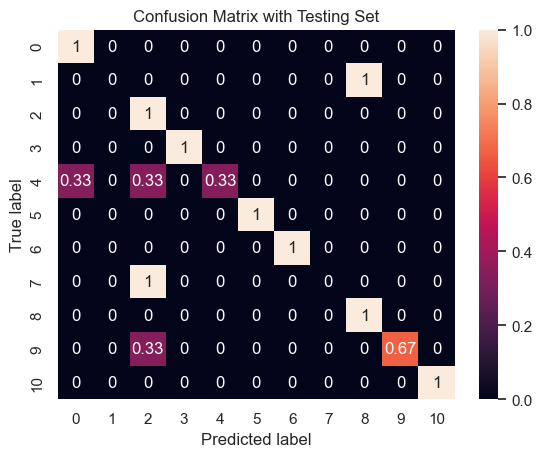

In [17]:
X_test_z = scaler.transform(X_test)
# Predict in test
y_pred = clf.predict(X_test_z)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {accuracy}")

# Confusion Matrix
confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()

sns.heatmap(confmat, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix with Testing Set")
plt.show()

In [18]:
# perform cross-validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_train_z, y_train, cv=5)
print(f"Accuracy scores of all models: {scores}")
print(f"Mean accuracy across all models: {np.mean(scores)}")

Accuracy scores of all models: [0.64705882 0.64705882 0.52941176 0.82352941 0.5625    ]
Mean accuracy across all models: 0.6419117647058824


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter search space
param_grid = {
    "n_estimators": [100,200,300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 4, 5],
    "subsample": [0.8, 1.0],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2, 4],
}

# Instantiation model
clf = GradientBoostingClassifier(random_state=42)

# grid search
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring="accuracy", cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_z, y_train)

# Output optimum parameter
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Evaluate the validation set with the best parameters
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_val_z)

# Recalculate the accuracy and confusion matrix
accuracy = accuracy_score(y_val, y_pred)
print(f"Test Accuracy after Optimization: {accuracy}")

confmat = confusion_matrix(y_val, y_pred, normalize="true")
sns.heatmap(confmat, annot=True)
plt.title("Confusion Matrix (After Optimization)")
plt.show()

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


In [24]:
# Evaluate the test set with the best parameters
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test_z)

# Recalculate the accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy after Optimization:0 {accuracy}")

confmat = confusion_matrix(y_test, y_pred, normalize="true")
sns.heatmap(confmat, annot=True)
plt.title("Confusion Matrix (After Optimization) with Test set")
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [ ]:
# perform cross-validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_clf, X_train_z, y_train, cv=5)
print(f"Accuracy scores of all models: {scores}")
print(f"Mean accuracy across all models: {np.mean(scores)}")

## 2. Generalization Across Subjects

### 2.1. Load EMG data of all 27 subjects

In [25]:
dataset_all = np.zeros((0, 60))
labels_all = np.zeros((0,))
for sub_idx in range(1, 27+1):

    # 1. Load data

    print('---- Loading Data From {sub_idx}')
    EMG_file_name = f's{sub_idx}/S{sub_idx}_A1_E1.mat'
    emg_data = loadmat(EMG_file_name)
    emg = emg_data["emg"].copy()
    stimulus = emg_data["restimulus"]
    repetition = emg_data["rerepetition"]
    print(f'    EMG: {emg.shape}, Stimulus {stimulus.shape}, Repetition {repetition.shape}')

    # 2. Perform bandpass filtering

    n_channels = emg.shape[1]
    fs = 2000
    time_steps = np.arange(0,emg.shape[0]/fs, 1/fs)
    bandpass_cutoff_frequencies_Hz = (15, 500)
    sos = butter(N=0, Wn=bandpass_cutoff_frequencies_Hz, fs=fs, btype="bandpass", output="sos")
    emg_filtered = sosfiltfilt(sos, emg.T).T
    powergrid_noise_frequencies_Hz = [harmonic_idx*50 for harmonic_idx in range(1,3)] # removing 50Hz noise and its harmonics
    for noise_frequency in powergrid_noise_frequencies_Hz:
        sos = butter(N=4, Wn=(noise_frequency - 2, noise_frequency + 2), fs=fs, btype="bandstop", output="sos")
        emg_filtered = sosfiltfilt(sos, emg_filtered.T).T

    # 3. Rectify
    emg_rectified = np.abs(emg_filtered)
    n_stimuli = len(np.unique(stimulus)) - 1
    n_repetitions = len(np.unique(repetition)) - 1
    n_channels = emg_rectified.shape[1]
    print(f'    n_stimuli: {n_stimuli}, n_repetitions: {n_repetitions}, n_channels: {n_channels}\n')

    # 4. Moving average
    mov_mean_size = 200
    mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size

    #initializing the data structure
    emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
    emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

    for stimuli_idx in range(n_stimuli):
        for repetition_idx in range(n_repetitions):
            idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
            emg_windows[stimuli_idx][repetition_idx] = emg_rectified[idx, :]
            emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0)

    dataset, labels = build_dataset_from_ninapro(
        emg=emg_filtered,
        stimulus=stimulus,
        repetition=repetition,
        features=[mav, std, maxav, rms, wl, ssc],
        feature_norm=True
    )
    dataset_all = np.vstack((dataset_all, dataset))
    labels_all = np.hstack((labels_all, labels))

---- Loading Data From {sub_idx}
    EMG: (101014, 10), Stimulus (101014, 1), Repetition (101014, 1)
    n_stimuli: 12, n_repetitions: 10, n_channels: 10

---- Loading Data From {sub_idx}
    EMG: (100686, 10), Stimulus (100686, 1), Repetition (100686, 1)
    n_stimuli: 12, n_repetitions: 10, n_channels: 10

---- Loading Data From {sub_idx}
    EMG: (100720, 10), Stimulus (100720, 1), Repetition (100720, 1)
    n_stimuli: 12, n_repetitions: 10, n_channels: 10

---- Loading Data From {sub_idx}
    EMG: (100835, 10), Stimulus (100835, 1), Repetition (100835, 1)
    n_stimuli: 12, n_repetitions: 10, n_channels: 10

---- Loading Data From {sub_idx}
    EMG: (100894, 10), Stimulus (100894, 1), Repetition (100894, 1)
    n_stimuli: 12, n_repetitions: 10, n_channels: 10

---- Loading Data From {sub_idx}
    EMG: (101083, 10), Stimulus (101083, 1), Repetition (101083, 1)
    n_stimuli: 12, n_repetitions: 10, n_channels: 10

---- Loading Data From {sub_idx}
    EMG: (100817, 10), Stimulus (1008

n_training: 2268, n_validation: 486, n_test: 486
Accuracy score: 0.7160493827160493


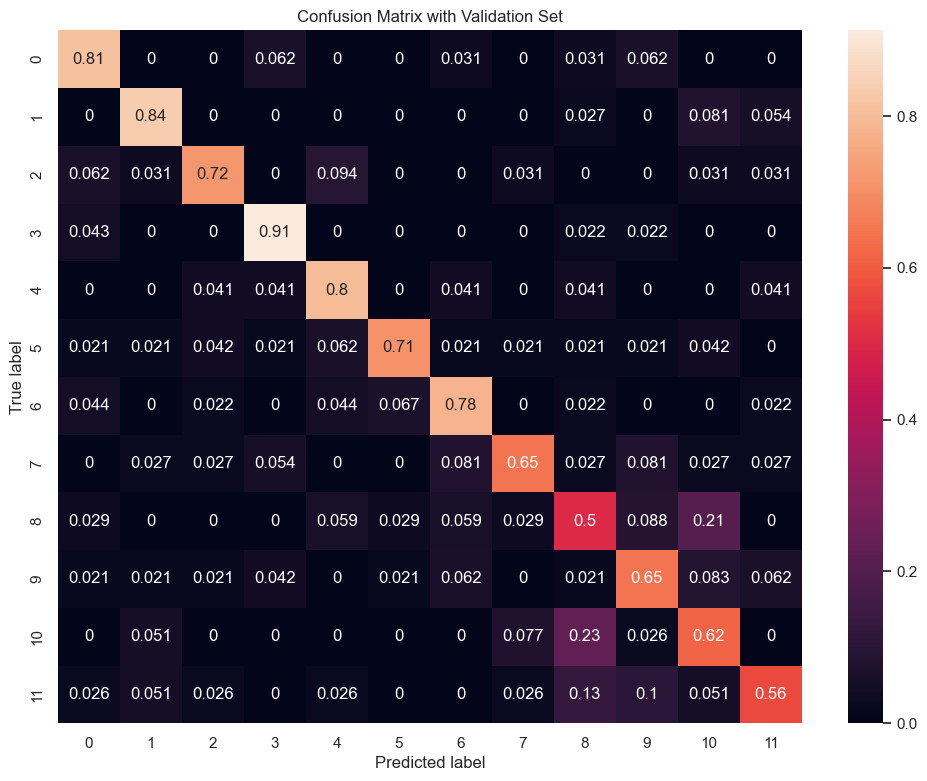

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Train:Validation:Test=70:15:15
X_train, X_temp, y_train, y_temp = train_test_split(dataset_all, labels_all, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'n_training: {X_train.shape[0]}, n_validation: {X_val.shape[0]}, n_test: {X_test.shape[0]}')

# Normalizing the data
# StandardScaler is used to scale the features so that they have a mean of 0 and a standard deviation of 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z = scaler.transform(X_val)

# Classifier
clf = GradientBoostingClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
clf.fit(X_train_z, y_train)

# Predict in validation
y_pred = clf.predict(X_val_z)

# Accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy score: {accuracy}")

# Confusion Matrix
confmat = confusion_matrix(y_val, y_pred, normalize="true")
fig, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(confmat, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix with Validation Set")
plt.show()

Accuracy score: 0.6831275720164609


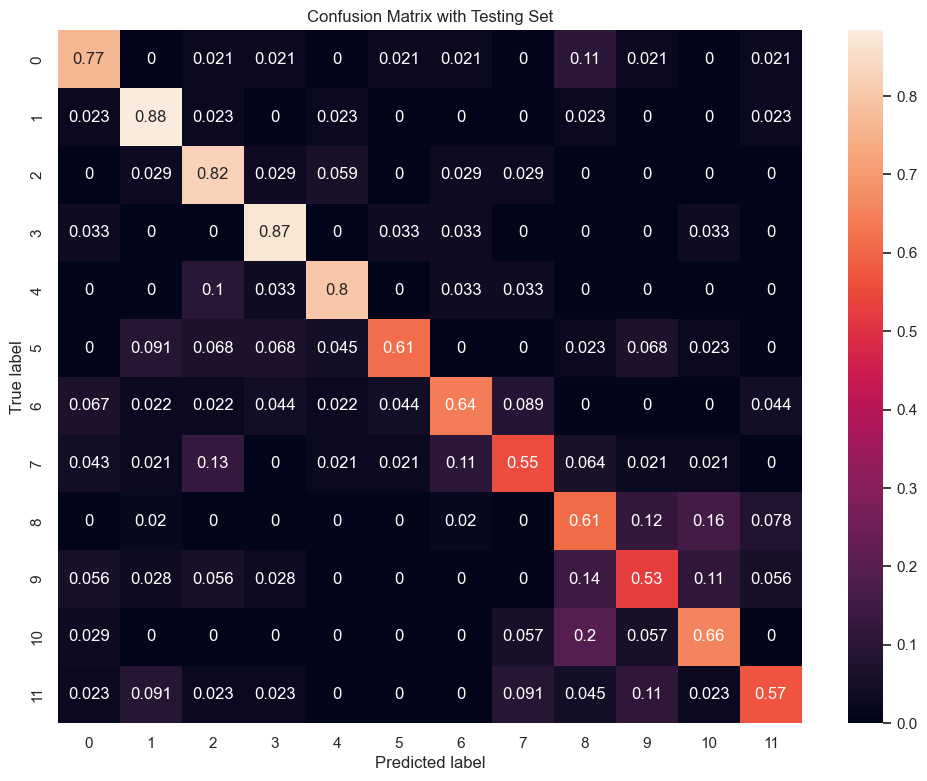

In [27]:
X_test_z = scaler.transform(X_test)
# Predict in test
y_pred = clf.predict(X_test_z)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {accuracy}")

# Confusion Matrix
confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(confmat, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix with Testing Set")
plt.show()

In [28]:
# perform cross-validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_train_z, y_train, cv=5)
print(f"Accuracy scores of all models: {scores}")
print(f"Mean accuracy across all models: {np.mean(scores)}")

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter search space
param_grid = {
    "n_estimators": [100,200,300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 4, 5],
    "subsample": [0.8, 1.0],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2, 4],
}

# Instantiation model
clf = GradientBoostingClassifier(random_state=42)

# grid search
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring="accuracy", cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_z, y_train)

# Output optimum parameter
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Evaluate the validation set with the best parameters
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_val_z)

# Recalculate the accuracy and confusion matrix
accuracy = accuracy_score(y_val, y_pred)
print(f"Test Accuracy after Optimization: {accuracy}")

confmat = confusion_matrix(y_val, y_pred, normalize="true")
sns.heatmap(confmat, annot=True)
plt.title("Confusion Matrix (After Optimization)")
plt.show()

In [ ]:

# Evaluate the test set with the best parameters
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test_z)

# Recalculate the accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy after Optimization:0 {accuracy}")

confmat = confusion_matrix(y_test, y_pred, normalize="true")
sns.heatmap(confmat, annot=True)
plt.title("Confusion Matrix (After Optimization) with Test set")
plt.show()